# Overview

## FAT2019 1st place solution (CNN model)

- https://github.com/lRomul/argus-freesound

MFCC等を使用するのはこれまでと同様だが、それを画像認識に見立てて処理をする（つまり生波形を扱わない）ことがこれまでと異なっている。勉強のため、モデルを組んでみた。この Kaggle のモデルは、attention などさらに手の込んだことをしているが、簡素なものを作成した。

# ライブラリの読み込み

In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR10

import librosa

In [9]:
# 適宜編集してみる
CSV_PATH = "../"
MEL_PATH = "../"

# データ読み込み

以下でデータ読み込み用の関数を定義する。前処理として以下の操作を行っている

- 無音部分の削除（librosa.trim） : 読み込んだデータの開始・終了部分の 60dB 以下を落とす
- 最小サンプル数以上を担保する：サンプル数の下限（$s_{\text{min}}$）を設定し、それ以上であることを担保する
    - トリムしたあとに、$s_{\text{min}}$ 以下であれば元のサンプルから再度トリミングする
    - それでも達しなかった場合（ex. そもそもが短い音源であった場合）、最小サンプル数になるように左右にゼロ埋めをする (`np.pad(...,'constant')`)

In [3]:
class ConfigAudio():
    sampling_rate = 44100
    hop_length = 345 * 2
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    min_seconds = 0.5

config = ConfigAudio()

print("最小サンプル数", int(config.min_seconds * config.sampling_rate))

最小サンプル数 22050


In [4]:
import numpy as np
import librosa
import librosa.display

def read_audio(file_path):
    min_samples = int(config.min_seconds * config.sampling_rate)
    try:
        y, sr = librosa.load(file_path, sr=config.sampling_rate)
        trim_y, trim_idx = librosa.effects.trim(y)  # Trim leading and trailing silence from an audio signal. top_db=default(60)

        if len(trim_y) < min_samples:
            center = (trim_idx[1] - trim_idx[0]) // 2
            left_idx = max(0, center - min_samples // 2)
            right_idx = min(len(y), center + min_samples // 2)
            trim_y = y[left_idx:right_idx]

            if len(trim_y) < min_samples:
                padding = min_samples - len(trim_y)
                offset = padding // 2
                trim_y = np.pad(trim_y, (offset, padding - offset), 'constant')
        return trim_y
    
    except BaseException as e:
        print(f"Exception while reading file {e}")
        return np.zeros(min_samples, dtype=np.float32)


def audio_to_melspectrogram(audio):
    spectrogram = librosa.feature.melspectrogram(audio,
                                                 sr=config.sampling_rate,
                                                 n_mels=config.n_mels,
                                                 hop_length=config.hop_length,
                                                 n_fft=config.n_fft,
                                                 fmin=config.fmin,
                                                 fmax=config.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

    
def read_as_melspectrogram(file_path, time_stretch=1.0, pitch_shift=0.0):
    x = read_audio(file_path)
    
    if time_stretch != 1.0:
        x = librosa.effects.time_stretch(x, time_stretch)

    if pitch_shift != 0.0:
        librosa.effects.pitch_shift(x, config.sampling_rate, n_steps=pitch_shift)

    mels = audio_to_melspectrogram(x)
    return mels

In [5]:
def show_melspectrogram(mels, title='Log-frequency power spectrogram'):
    import matplotlib.pyplot as plt

    librosa.display.specshow(mels, x_axis='time', y_axis='log',
                             sr=config.sampling_rate, hop_length=config.hop_length,
                             fmin=config.fmin, fmax=config.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()


def listen_audio(file_path):
    x = read_audio(file_path)
    import IPython
    IPython.display.display(IPython.display.Audio(x, rate=config.sampling_rate))
    return

### 使い方について

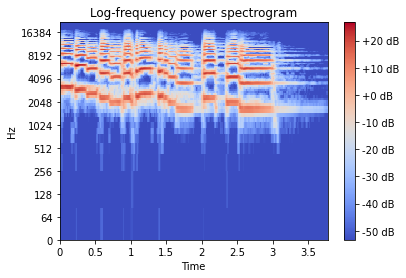

In [6]:
mels = read_as_melspectrogram(librosa.ex("trumpet"))
show_melspectrogram(mels)

In [7]:
listen_audio(librosa.ex("trumpet"))

## 事前変換用・読み込み用関数


In [8]:
import pickle

def convert_to_melspec():
    
    df = pd.read_csv( CSV_PATH + "train_label.csv")
    
    for idx, file in enumerate(df['file_name'].to_numpy()):
        if idx%500==0 :
            print(">>>>>>>>>", idx)

        mel = read_as_melspectrogram(f"{FILE_PATH}/{file}")
        
        new_file = file.split(".")[0]
        with open(f"{MEL_PATH}/{new_file}.pkl", "wb") as f:
            pickle.dump(mel, f)
    return


def load_melspec(file_list):
    mel_list = []
    for file in file_list:
        with open(f'{MEL_PATH}/{file}.pkl', "rb") as f:
            mel_list.append(pickle.load(f))
    return mel_list

### 変換

以下のスクリプトを実行することで、各オーディオファイルを対数スペクトログラムに変換できる。

In [9]:
convert = False
if convert:
    convert_to_melspec()

### 読み込み

In [11]:
df = pd.read_csv("../data/train_label.csv")
# remove wav extentions
df["file_name"] = df["file_name"].str.split(".", expand=True)[0]
tmp = load_melspec(df["file_name"].to_numpy())

In [12]:
len(tmp)

5000

# Augumentations

データ数のかさ増し（agumentation）のために、各種手法を用いる。ここでは、`torchvision.transforms` を利用して augmentation の定義、また `Dataset` を利用して学習の際に使用するデータセットを自動で用意するためのフレームワークを定義する。

In [13]:
transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
)

In [14]:
transform = transforms.Compose([
        transforms.Resize((240, 320)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [15]:
def image_crop(image, bbox):
    return image[bbox[1]:bbox[3], bbox[0]:bbox[2]]


def gauss_noise(image, sigma_sq):
    h, w = image.shape
    gauss = np.random.normal(0, sigma_sq, (h, w))
    gauss = gauss.reshape(h, w)
    image = image + gauss
    return image


# Source: https://www.kaggle.com/davids1992/specaugment-quick-implementation
def spec_augment(spec: np.ndarray,
                 num_mask=2,
                 freq_masking=0.15,
                 time_masking=0.20,
                 value=0):
    spec = spec.copy()
    num_mask = random.randint(1, num_mask)
    for i in range(num_mask):
        all_freqs_num, all_frames_num  = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking)

        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[f0:f0 + num_freqs_to_mask, :] = value

        time_percentage = random.uniform(0.0, time_masking)

        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[:, t0:t0 + num_frames_to_mask] = value
    return spec


class SpecAugment:
    def __init__(self,
                 num_mask=2,
                 freq_masking=0.15,
                 time_masking=0.20):
        self.num_mask = num_mask
        self.freq_masking = freq_masking
        self.time_masking = time_masking

    def __call__(self, image):
        return spec_augment(image,
                            self.num_mask,
                            self.freq_masking,
                            self.time_masking,
                            image.min())


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, trg=None):
        if trg is None:
            for t in self.transforms:
                image = t(image)
            return image
        else:
            for t in self.transforms:
                image, trg = t(image, trg)
            return image, trg


class UseWithProb:
    def __init__(self, transform, prob=.5):
        self.transform = transform
        self.prob = prob

    def __call__(self, image, trg=None):
        if trg is None:
            if random.random() < self.prob:
                image = self.transform(image)
            return image
        else:
            if random.random() < self.prob:
                image, trg = self.transform(image, trg)
            return image, trg


class OneOf:
    def __init__(self, transforms, p=None):
        self.transforms = transforms
        self.p = p

    def __call__(self, image, trg=None):
        transform = np.random.choice(self.transforms, p=self.p)
        if trg is None:
            image = transform(image)
            return image
        else:
            image, trg = transform(image, trg)
            return image, trg


class Flip:
    def __init__(self, flip_code):
        assert flip_code == 0 or flip_code == 1
        self.flip_code = flip_code

    def __call__(self, image):
        image = cv2.flip(image, self.flip_code)
        return image


class HorizontalFlip(Flip):
    def __init__(self):
        super().__init__(1)


class VerticalFlip(Flip):
    def __init__(self):
        super().__init__(0)


class GaussNoise:
    def __init__(self, sigma_sq):
        self.sigma_sq = sigma_sq

    def __call__(self, image):
        if self.sigma_sq > 0.0:
            image = gauss_noise(image,
                                np.random.uniform(0, self.sigma_sq))
        return image


class RandomGaussianBlur:
    '''Apply Gaussian blur with random kernel size
    Args:
        max_ksize (int): maximal size of a kernel to apply, should be odd
        sigma_x (int): Standard deviation
    '''
    def __init__(self, max_ksize=5, sigma_x=20):
        assert max_ksize % 2 == 1, "max_ksize should be odd"
        self.max_ksize = max_ksize // 2 + 1
        self.sigma_x = sigma_x

    def __call__(self, image):
        kernel_size = tuple(2 * np.random.randint(0, self.max_ksize, 2) + 1)
        blured_image = cv2.GaussianBlur(image, kernel_size, self.sigma_x)
        return blured_image


class ImageToTensor:
    def __call__(self, image):
        delta = librosa.feature.delta(image)
        accelerate = librosa.feature.delta(image, order=2)
        image = np.stack([image, delta, accelerate], axis=0)
        image = image.astype(np.float32) / 100
        image = torch.from_numpy(image)
        return image


class RandomCrop:
    def __init__(self, size):
        self.size = size

    def __call__(self, signal):
        start = random.randint(0, signal.shape[1] - self.size)
        return signal[:, start: start + self.size]


class CenterCrop:
    def __init__(self, size):
        self.size = size

    def __call__(self, signal):

        if signal.shape[1] > self.size:
            start = (signal.shape[1] - self.size) // 2
            return signal[:, start: start + self.size]
        else:
            return signal


class PadToSize:
    def __init__(self, size, mode='constant'):
        assert mode in ['constant', 'wrap']
        self.size = size
        self.mode = mode

    def __call__(self, signal):
        if signal.shape[1] < self.size:
            padding = self.size - signal.shape[1]
            offset = padding // 2
            pad_width = ((0, 0), (offset, padding - offset))
            if self.mode == 'constant':
                signal = np.pad(signal, pad_width,
                                'constant', constant_values=signal.min())
            else:
                signal = np.pad(signal, pad_width, 'wrap')
        return signal


def get_transforms(train, size,
                   wrap_pad_prob=0.5,
                   resize_scale=(0.8, 1.0),
                   resize_ratio=(1.7, 2.3),
                   resize_prob=0.33,
                   spec_num_mask=2,
                   spec_freq_masking=0.15,
                   spec_time_masking=0.20,
                   spec_prob=0.5):
    if train:
        transforms = Compose([
            OneOf([
                PadToSize(size, mode='wrap'),
                PadToSize(size, mode='constant'),
            ], p=[wrap_pad_prob, 1 - wrap_pad_prob]),
            RandomCrop(size),
            #UseWithProb(
            #    RandomResizedCrop(scale=resize_scale, ratio=resize_ratio),
            #    prob=resize_prob
            #),
            UseWithProb(SpecAugment(num_mask=spec_num_mask,
                                    freq_masking=spec_freq_masking,
                                    time_masking=spec_time_masking), spec_prob),
            ImageToTensor()
        ])
    else:
        transforms = Compose([
            PadToSize(size),
            CenterCrop(size),
            ImageToTensor()
        ])
    return transforms

## Datasetの定義

- https://qiita.com/takurooo/items/e4c91c5d78059f92e76d

全データをどう扱うかを定義する。`tocrch.utils.data.DataLoader` を継承して新たにデータセットクラスを定義する。

- \_\_len\_\_ の実装が必要（`len(obj)`でコールされる関数）
- \_\_getitem\_\_ の実装が必要（`obj[idx]`でコールされる関数）

定義された Dataset は Dataloader を用いてミニバッチ毎にデータが分割される。

In [89]:
class ContestData(Dataset):
    def __init__(self, file_list, label_list, transform=None, mixer=None):
        
        self.file_list = file_list

        self.label_list = label_list

        self.transform = transform
        self.mixer = mixer
        
        self.images_list = []
        for pkl_file in self.file_list:
            with open(f'{MEL_PATH}/{pkl_file}.pkl', "rb") as f:
                self.images_list.append(pickle.load(f))
        
        return
    

    def __len__(self):
        return len(self.file_list)
    
    
    def __getitem__(self, idx):
        image = self.images_list[idx].copy()
        label = self.label_list[idx]
        
        if self.transform is not None:
            image = self.transform(image)
        
        if self.mixer is not None:
            image, label = self.mixer(self, image, label)
        
        image = image.to(torch.float32)
        label = label.astype(np.float32)
        return image, label

### 使い方 (Dataset)

In [17]:
usetest_dataset = ContestData(df["file_name"].to_numpy()[:100], df["speaker_id"].to_numpy()[:100])

print(len(usetest_dataset))
print(usetest_dataset[0])

100
(array([[-32.358467, -30.812454, -31.149939, ..., -31.313225, -30.644382,
        -31.321835],
       [-36.298058, -34.843765, -34.74566 , ..., -35.3933  , -34.35412 ,
        -34.159668],
       [-41.16734 , -46.995735, -54.975544, ..., -55.750908, -53.305416,
        -46.52689 ],
       ...,
       [-64.06102 , -64.06102 , -64.06102 , ..., -64.06102 , -64.06102 ,
        -64.06102 ],
       [-64.06102 , -64.06102 , -64.06102 , ..., -64.06102 , -64.06102 ,
        -64.06102 ],
       [-64.06102 , -64.06102 , -64.06102 , ..., -64.06102 , -64.06102 ,
        -64.06102 ]], dtype=float32), 'P001')


以上をよく見ると、Dataset は100個のデータを保持していて、1つ目を試しにprintするとメルスペクトログラムデータとそのラベルを返していることが分かる。
また、transformを定義しておけばデータの整形も同時に行うことができる。

In [18]:
usetest_dataset = ContestData(df["file_name"].to_numpy()[:2], df["speaker_id"].to_numpy()[:2], transform=get_transforms(train=True, size=256))

### 使い方 (Dataloader)

学習のときは、dataloader のループをさらに epoch のループでかぶせる。

In [19]:
usetest_dataset = ContestData(df["file_name"].to_numpy()[:1], df["speaker_id"].to_numpy()[:1], transform=get_transforms(train=True, size=256))
usetest_loader = DataLoader(usetest_dataset, batch_size=2, shuffle=True)
print(len(usetest_loader))

for i in usetest_loader:
    print(i)

1
[tensor([[[[-3.0609e-01, -2.7048e-01, -2.6358e-01,  ..., -3.0143e-01,
           -2.9551e-01, -3.0675e-01],
          [-3.4228e-01, -2.7941e-01, -2.5532e-01,  ..., -3.3882e-01,
           -3.4231e-01, -3.3211e-01],
          [-4.8272e-01, -2.7982e-01, -2.7549e-01,  ..., -4.4078e-01,
           -4.5178e-01, -4.2201e-01],
          ...,
          [-6.4061e-01, -6.4061e-01, -6.4061e-01,  ..., -6.4061e-01,
           -6.4061e-01, -6.4061e-01],
          [-6.4061e-01, -6.4061e-01, -6.4061e-01,  ..., -6.4061e-01,
           -6.4061e-01, -6.4061e-01],
          [-6.4061e-01, -6.4061e-01, -6.4061e-01,  ..., -6.4061e-01,
           -6.4061e-01, -6.4061e-01]],

         [[-2.9113e-03, -2.9113e-03, -2.9113e-03,  ...,  4.1797e-04,
            4.1797e-04,  4.1797e-04],
          [-5.4113e-03, -5.4113e-03, -5.4113e-03,  ..., -2.1999e-04,
           -2.1999e-04, -2.1999e-04],
          [-1.5038e-02, -1.5038e-02, -1.5038e-02,  ..., -2.9257e-03,
           -2.9257e-03, -2.9257e-03],
          ...,
  

## データの構造

In [20]:
train_dataset = ContestData(df["file_name"].to_numpy()[:1], df["speaker_id"].to_numpy()[:1], transform=get_transforms(train=True, size=256))
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

for idx, data in enumerate(train_loader):
    inputs, labels = data
    
    print(inputs.shape)
    print(labels)

torch.Size([1, 3, 128, 256])
('P001',)


## SpecAugment

## Mixup

# モデル
## CNNモデル

入力はとりあえず、$(3\times 128 \times 256)$ で固定している（前から順に、入力チャンネル数、$H$、$W$）。

### Conv2d

2次元畳み込み層。`Conv2d(in_channels, out_channels, kernel_size,...)` 

- https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

### MaxPool2d
### Linear

In [59]:
class ContestNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1 = nn.Linear(16 * 29 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 500)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

このモデルを使って、正しく forward できるかを調整する。

In [60]:
net = ContestNet()
inputs = torch.randn(1,3,128,256)
net(inputs).shape

torch.Size([1, 500])

# 学習

In [10]:
df = pd.read_csv(f"{CSV_PATH}/train_label.csv")
# remove wav extentions
df["file_name"] = df["file_name"].str.split(".", expand=True)[0]
df = pd.get_dummies(df, columns=['speaker_id',])

FileNotFoundError: [Errno 2] No such file or directory: '..//train_label.csv'

## 前処理

KFoldをする前に、学習に一切使用しない test data を切り出しておく必要がある。そのため例のごとく、train_test_split を使用する。

In [90]:
df = pd.read_csv(f"{CSV_PATH}/train_label.csv")
df["file_name"] = df["file_name"].str.split(".", expand=True)[0] # remove wav extentions
df = pd.get_dummies(df, columns=['speaker_id',])

X_train, X_test, y_train, y_test = train_test_split(df['file_name'].to_numpy(), df.iloc[:, 3:].to_numpy(), test_size=0.1)

dataset = ContestData(X_train, y_train, transform=get_transforms(train=True, size=256))

In [92]:
net = ContestNet()

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# print(model)

kf = KFold(n_splits=2)
for fold, (trn_idx, val_idx) in enumerate(kf.split(X_train, y_train)):

    train_dataset = Subset(dataset, trn_idx)
    train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
    
    val_dataset = Subset(dataset, val_idx)
    val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
    
    for epoch in range(1):        
        
        running_loss = 0.0
        
        for idx, data in enumerate(train_loader):
            inputs, labels = data
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if idx%50 == 0:
                print(epoch+1, idx+1, running_loss/200)
                running_loss = 0.0

len(train_loader) :  300
1 1 3.014372894540429e-05
1 201 0.006000239928252995
len(train_loader) :  300
1 1 3.0025616288185118e-05
1 201 0.0057959729479625825
len(train_loader) :  300
1 1 2.8138873167335986e-05
1 201 0.005653494943398982
